El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Preparación de datos

### Importe de librerias

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
import time
#import seaborn as sns

### Carga de Datos

In [2]:
df=pd.read_csv('car_data.csv')
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ', '_')   
dfa = df.rename(columns={'datecrawled':'fecha_recoleccion','brand':'empresa','engine_fuel_type': 'combustible','gearbox':'caja','power':'potencia','model':'modelo','mileage':'millas','registrationmonth':'mes_registro','notrepaired':'sin_reparacion','datecreated':'fecha_creacion','postalcode':'postal','lastseen':'ultimovisto','price':'precio','vehicletype':'tipo_vehiculo','registrationyear':'año','fueltype':'tipo_combustible' })
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   mileage            354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  notrepaired        283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
dfa

,fecha_recoleccion,precio,tipo_vehiculo,año,caja,potencia,modelo,millas,mes_registro,tipo_combustible,empresa,sin_reparacion,fecha_creacion,numberofpictures,postal,ultimovisto
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15


#### Consideraciones
- Analizare los datos en busca de datos nulos y eliminare columnas que considere inaportantes a la hora de yo mismo ir a comprar un auto
- Los datos nulos en caso de ser demasiados en la columna, como parece en la de reparaciones, las eliminare de plano para no tener qwuue eliminar mas datos e incluir esa columna.

In [4]:
dfa.isna().sum()

fecha_recoleccion        0
precio                   0
tipo_vehiculo        37490
año                      0
caja                 19833
potencia                 0
modelo               19705
millas                   0
mes_registro             0
tipo_combustible     32895
empresa                  0
sin_reparacion       71154
fecha_creacion           0
numberofpictures         0
postal                   0
ultimovisto              0
dtype: int64

#### Tengo 71k registros vacios en el apartado de reparado o no, aun asi me parece relevante sa informacion a la hora de comprar. El total es de 354369 registros, asi que serian como la quinta parte de registros la que perderia, aun asi quedaria con un buen numero para generar el modelo

In [5]:
dfa.dropna(inplace=True)
dfa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 245814 entries, 3 to 354367
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   fecha_recoleccion  245814 non-null  object
 1   precio             245814 non-null  int64 
 2   tipo_vehiculo      245814 non-null  object
 3   año                245814 non-null  int64 
 4   caja               245814 non-null  object
 5   potencia           245814 non-null  int64 
 6   modelo             245814 non-null  object
 7   millas             245814 non-null  int64 
 8   mes_registro       245814 non-null  int64 
 9   tipo_combustible   245814 non-null  object
 10  empresa            245814 non-null  object
 11  sin_reparacion     245814 non-null  object
 12  fecha_creacion     245814 non-null  object
 13  numberofpictures   245814 non-null  int64 
 14  postal             245814 non-null  int64 
 15  ultimovisto        245814 non-null  object
dtypes: int64(7), object(9)
me

## Entrenamiento del modelo 

In [6]:
dfb = dfa[dfa['precio'] > 100]
dfb.drop(['fecha_recoleccion', 'fecha_creacion', 'ultimovisto','numberofpictures','mes_registro'], axis=1, inplace=True)

C:\Users\roman\AppData\Local\Temp\ipykernel_19392\3305030410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb.drop(['fecha_recoleccion', 'fecha_creacion', 'ultimovisto','numberofpictures','mes_registro'], axis=1, inplace=True)


In [7]:
#dfb[dfb['precio']<500]
bins = [0, 2000, 4000, 6000, 8000, 10000, 15000, 20000]  # np.inf para el último intervalo abierto


labels = ['0-2000', '2001-4000', '4001-6000', '6001-8000', '8001-10000', '10001-15000', ' 15001-20000']
df_aux=dfb.copy()
df_aux['precio_int'] = pd.cut(
    dfb['precio'],
    bins=bins,
    labels=labels,
    right=True,       # Intervalos cerrados por la derecha: (0, 500] -> 0 < x <= 500
    include_lowest=True  # Incluye el valor más bajo (0)
)
df_aux

,precio,tipo_vehiculo,año,caja,potencia,modelo,millas,tipo_combustible,empresa,sin_reparacion,postal,precio_int
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,91074,0-2000
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,60437,2001-4000
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,33775,0-2000
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,67112,2001-4000
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no,96224,0-2000
...,...,...,...,...,...,...,...,...,...,...,...,...
354360,3999,wagon,2005,manual,3,3er,150000,gasoline,bmw,no,81825,2001-4000
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes,96465,2001-4000
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no,26624,0-2000
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,26135,0-2000


In [8]:
dfb['precio'].describe()

count    241469.000000
mean       5217.363699
std        4709.621414
min         101.000000
25%        1500.000000
50%        3500.000000
75%        7500.000000
max       20000.000000
Name: precio, dtype: float64

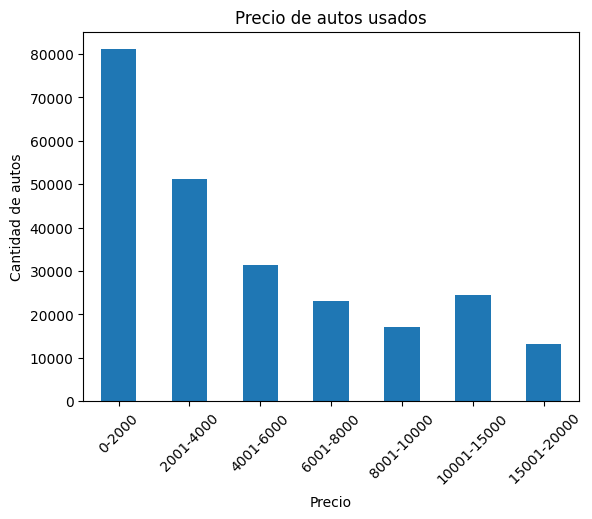

In [9]:

df_aux['precio_int'].value_counts().sort_index().plot(kind='bar', rot=45)
plt.xlabel('Precio')
plt.ylabel('Cantidad de autos')
plt.title('Precio de autos usados')
plt.show()

#### Que se hizo.
- Se eliminaron datos nan, dejando las columnas que **YO** considero importantes a la hora de comprar un vehiculo.
- se eliminaron tambien los precios iguales a cero, debido a que alguien no lo puso y sera mi columna de prediccion, asi que necesito datos limpios totalmente, tambien se eliminaron precios bajos
- solo a modo de referencia se muestran las categorias de precios con una separacion arbitraria


In [10]:
cat=['empresa', 'caja', 'tipo_vehiculo', 'tipo_combustible', 'modelo', 'sin_reparacion']
num =['potencia', 'millas', 'año', 'postal']
dfb[num]= dfb[num].astype('int')
dfb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 241469 entries, 3 to 354367
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   precio            241469 non-null  int64 
 1   tipo_vehiculo     241469 non-null  object
 2   año               241469 non-null  int64 
 3   caja              241469 non-null  object
 4   potencia          241469 non-null  int64 
 5   modelo            241469 non-null  object
 6   millas            241469 non-null  int64 
 7   tipo_combustible  241469 non-null  object
 8   empresa           241469 non-null  object
 9   sin_reparacion    241469 non-null  object
 10  postal            241469 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 22.1+ MB


C:\Users\roman\AppData\Local\Temp\ipykernel_19392\3671836339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb[num]= dfb[num].astype('int')


In [11]:
class PreprocessData:
    """
    A class for preprocessing data before training ML models.
    
    Handles both categorical variables (using OneHotEncoder) and numerical variables 
    (using StandardScaler). Ensures consistent preprocessing between train and test sets.
    
    Attributes:
        numeric_vars (list): List of numerical column names to preprocess
        categorical_vars (list): List of categorical column names to preprocess
        ohe (OneHotEncoder): Fitted one-hot encoder for categorical variables
        scaler (StandardScaler): Fitted scaler for numerical variables
        train_names (list): Column names from training set to ensure consistency
    """

    def __init__(self, numeric_vars=None, categorical_vars=None):
        """
        Initialize the preprocessor.
        
        Args:
            numeric_vars (list, optional): Column names for numerical variables
            categorical_vars (list, optional): Column names for categorical variables
        """
        self.numeric_vars = numeric_vars
        self.categorical_vars = categorical_vars

    def preprocess(self, data, set_data="train"):
        """
        Main preprocessing method that handles both categorical and numerical data.
        
        Args:
            data (DataFrame): Input data to preprocess
            set_data (str): Either "train" or "test" to determine processing mode
            
        Returns:
            DataFrame: Preprocessed data with consistent column structure
        """
        datasets = []
        
        # Process categorical variables if specified
        if self.categorical_vars:
            categorical_values = self.preprocess_categorical(data, set_data)
            datasets.append(categorical_values)
        
        # Process numerical variables if specified
        if self.numeric_vars:
            num_values = self.preprocess_numerical(data, set_data)
            datasets.append(num_values)
        
        # Combine all processed datasets
        processed_data = pd.concat(datasets, axis=1)
        
        if set_data=="train":
            # Store column names from training set
            self.train_names = processed_data.columns.tolist()
        else:
            # Add missing columns with zeros for test set consistency
            remaining_names = list(set(self.train_names) - set(processed_data.columns.tolist()))
            if remaining_names:
                processed_data[remaining_names] = 0
        
        # Return data with same column order as training set
        return processed_data[self.train_names]

    def preprocess_categorical(self, data, set_data):
        """
        Preprocess categorical variables using OneHotEncoder.
        
        Args:
            data (DataFrame): Input data
            set_data (str): "train" to fit encoder, "test" to transform only
            
        Returns:
            DataFrame: One-hot encoded categorical data
        """
        # Fill NaN values and convert to string
        data[self.categorical_vars] = data[self.categorical_vars].astype(str).fillna("unknown")
        
        if set_data == "train":
            # Fit and transform for training data
            self.ohe = OneHotEncoder(handle_unknown="ignore", drop='first')
            out = self.ohe.fit_transform(data[self.categorical_vars])
            return pd.DataFrame(out.toarray(), columns=self.ohe.get_feature_names_out(), index=data.index)
        else:
            # Transform only for test data
            out = self.ohe.transform(data[self.categorical_vars])
            return pd.DataFrame(out.toarray(), columns=self.ohe.get_feature_names_out(), index=data.index)

    def preprocess_numerical(self, data, set_data):
        """
        Preprocess numerical variables using StandardScaler.
        
        Args:
            data (DataFrame): Input data
            set_data (str): "train" to fit scaler, "test" to transform only
            
        Returns:
            DataFrame: Scaled numerical data
        """
        num_values = data[self.numeric_vars].copy()
        
        if set_data == "train":
            # Fit and transform for training data
            std_scaler = StandardScaler()
            num_values[self.numeric_vars] = std_scaler.fit_transform(num_values)
            self.scaler = std_scaler
        else:
            # Transform only for test data using fitted scaler
            num_values[self.numeric_vars] = self.scaler.transform(num_values)
            
        return num_values

In [12]:
data = dfb[num + cat]
data

,potencia,millas,año,postal,empresa,caja,tipo_vehiculo,tipo_combustible,modelo,sin_reparacion
3,75,150000,2001,91074,volkswagen,manual,small,petrol,golf,no
4,69,90000,2008,60437,skoda,manual,small,gasoline,fabia,no
5,102,150000,1995,33775,bmw,manual,sedan,petrol,3er,yes
6,109,150000,2004,67112,peugeot,manual,convertible,petrol,2_reihe,no
10,105,150000,2004,96224,mazda,manual,sedan,petrol,3_reihe,no
...,...,...,...,...,...,...,...,...,...,...
354360,3,150000,2005,81825,bmw,manual,wagon,gasoline,3er,no
354362,225,150000,2004,96465,seat,manual,sedan,petrol,leon,yes
354363,0,150000,2000,26624,opel,manual,bus,petrol,zafira,no
354366,101,125000,2000,26135,smart,auto,convertible,petrol,fortwo,no


In [13]:

target = dfb['precio']
train_data, valid_data, train_target, valid_target = train_test_split(data, target, test_size=0.25, random_state=12345)
preprocessor = PreprocessData(numeric_vars=num, categorical_vars=cat)
data_train = preprocessor.preprocess(train_data, set_data="train")
data_val = preprocessor.preprocess(valid_data, set_data="test")
data_train

,empresa_audi,empresa_bmw,empresa_chevrolet,empresa_chrysler,empresa_citroen,empresa_dacia,empresa_daewoo,empresa_daihatsu,empresa_fiat,empresa_ford,...,modelo_yaris,modelo_yeti,modelo_ypsilon,modelo_z_reihe,modelo_zafira,sin_reparacion_yes,potencia,millas,año,postal
328484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.168885,0.615772,-0.489941,-0.924568
331409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.382556,-2.083716,1.308147,1.504664
203924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.345039,-1.813767,1.308147,-1.072458
85574,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.558711,0.615772,-0.489941,1.338448
66996,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.084637,-2.353665,0.981222,-0.484619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.475241,-0.059100,0.327372,0.580790
195476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.122153,0.615772,-0.980328,-0.704691
191237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.145908,0.615772,-0.816866,0.796444
113320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.919457,-0.059100,0.981222,-0.264044


#### Consideraciones
- Se usa la clase para OHE y normalizacion que nos facilito Juan Santos en uno de los webinars
- Aunque algunos modelos no necesitan OHE ni normalizacion puesto que tienen su propia manera para hacerlo, lo hago para mejorar el desempeño de todos los modelos.

## Modelo 'Dummy'
- LinearRegression

In [14]:
model_dummy = LinearRegression()
time_start_lr = time.time()
model_dummy.fit(data_train, train_target)
predictions_lr = model_dummy.predict(data_val)
pre_lr_train = model_dummy.predict(data_train)
mse_train_lr = mean_squared_error(train_target, pre_lr_train)**0.5 
mse_test_lr = mean_squared_error(valid_target, predictions_lr)**0.5
time_end_lr = time.time() - time_start_lr

print(f"Modelo Dummy - MSE entrenamiento: {mse_train_lr:.2f}, Validacion: {mse_test_lr:.2f}")
print(f"Tiempo de entrenamiento: {time_end_lr:.2f} segundos")

Modelo Dummy - MSE entrenamiento: 2666.41, Validacion: 2692.01
Tiempo de entrenamiento: 3.26 segundos


In [15]:
models={'modelo':[], 'mse_train':[], 'mse_test':[],'tiempo_entrenamiento':[]}
models['modelo'].append('Dummy')
models['mse_train'].append(mse_train_lr) 
models['mse_test'].append(mse_test_lr)
models['tiempo_entrenamiento'].append(time_end_lr)
models



{'modelo': ['Dummy'],
 'mse_train': [2666.409244044788],
 'mse_test': [2692.010874607336],
 'tiempo_entrenamiento': [3.2550573348999023]}

In [16]:
model_rf = RandomForestRegressor(random_state=12345,n_estimators=100, max_depth=None, n_jobs=-4)
time_start_rf = time.time()
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5]
}
cv_rf = GridSearchCV(model_rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-4)
cv_rf.fit(data_train, train_target)  
time_end_rf = time.time() - time_start_rf 


In [17]:
best_model_rf = cv_rf.best_estimator_
mse_rf_train = mean_squared_error(train_target, best_model_rf.predict(data_train))**0.5
predictions_rf = best_model_rf.predict(data_val)
mse_rf_test = mean_squared_error(valid_target, predictions_rf)**0.5

models['modelo'].append('RandomForest')
models['mse_train'].append(mse_rf_train)
models['mse_test'].append(mse_rf_test)
models['tiempo_entrenamiento'].append(time_end_rf)

In [ ]:
model_xgb = xgb.XGBRegressor(random_state=12345)
time_start_xgb = time.time()
param_grid_gxb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
cv_xgb = GridSearchCV(model_xgb, param_grid_gxb, cv=5, scoring='neg_mean_squared_error', n_jobs=-3)
cv_xgb.fit(data_train, train_target)
time_end_xgb = time.time() - time_start_xgb


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-3,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

In [ ]:
best_model_xgb = cv_xgb.best_estimator_ 
mse_xgb_train = mean_squared_error(train_target, best_model_xgb.predict(data_train))**0.5
predictions_xgb = best_model_xgb.predict(data_val)  
mse_xgb_test = mean_squared_error(valid_target, predictions_xgb) **0.5

models['modelo'].append('XGBoost')
models['mse_train'].append(mse_xgb_train)      
models['mse_test'].append(mse_xgb_test)
models['tiempo_entrenamiento'].append(time_end_xgb)
models

{'modelo': ['Dummy', 'RandomForest', 'XGBoost'],
 'mse_train': [2666.409244044788, 2351.7869962556883, 1402.8652821992566],
 'mse_test': [2692.010874607336, 2347.6998655706693, 1564.684632761503],
 'tiempo_entrenamiento': [3.2550573348999023,
  442.46251249313354,
  144.71040201187134]}

In [21]:
model_lgb = lgb.LGBMRegressor(random_state=12345, force_col_wise=True)
time_start_lgb = time.time()
param_grid_lgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}
cv_lgb = GridSearchCV(model_lgb, param_grid_lgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-4)
cv_lgb.fit(data_train, train_target)

time_end_lgb = time.time() - time_start_lgb
#%%time

[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 181101, number of used features: 285
[LightGBM] [Info] Start training from score 5216.869719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [ ]:
best_model_lgb = cv_lgb.best_estimator_
mse_lgb_train = mean_squared_error(train_target, best_model_lgb.predict(data_train))**0.5    
predictions_lgb = best_model_lgb.predict(data_val)
mse_lgb_test = mean_squared_error(valid_target, predictions_lgb)**0.5

models['modelo'].append('LightGBM')    
models['mse_train'].append(mse_lgb_train)
models['mse_test'].append(mse_lgb_test)
models['tiempo_entrenamiento'].append(time_end_lgb)

In [25]:
model_cb = cb.CatBoostRegressor(random_state=12345, verbose=0)
time_start_cb = time.time()
param_grid_cb = {
    'iterations': [100, 200],
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}
cv_cb = GridSearchCV(model_cb, param_grid_cb, cv=5, scoring='neg_mean_squared_error', n_jobs=-4)
cv_cb.fit(data_train, train_target)
time_end_cb = time.time() - time_start_cb

In [ ]:
best_model_cb = cv_cb.best_estimator_
mse_cb_train = mean_squared_error(train_target, best_model_cb.predict(data_train))**0.5
predictions_cb = best_model_cb.predict(data_val)
mse_cb_test = mean_squared_error(valid_target, predictions_cb)**0.5
models['modelo'].append('CatBoost')
models['mse_train'].append(mse_cb_train)
models['mse_test'].append(mse_cb_test)
models['tiempo_entrenamiento'].append(time_end_cb)

models_df = pd.DataFrame(models)
models_df


,modelo,mse_train,mse_test,tiempo_entrenamiento
0,Dummy,2666.409244,2692.010875,3.255057
1,RandomForest,2351.786996,2347.699866,442.462512
2,XGBoost,1402.865282,1564.684633,144.710402
3,LightGBM,1505.903505,1582.672064,68.096227
4,CatBoost,1549.916504,1603.415273,131.619638


In [28]:
models

{'modelo': ['Dummy', 'RandomForest', 'XGBoost', 'LightGBM', 'CatBoost'],
 'mse_train': [2666.409244044788,
  2351.7869962556883,
  1402.8652821992566,
  1505.9035048679677,
  1549.9165042453765],
 'mse_test': [2692.010874607336,
  2347.6998655706693,
  1564.684632761503,
  1582.6720637440087,
  1603.4152731806548],
 'tiempo_entrenamiento': [3.2550573348999023,
  442.46251249313354,
  144.71040201187134,
  68.09622740745544,
  131.61963772773743]}

## Análisis del modelo

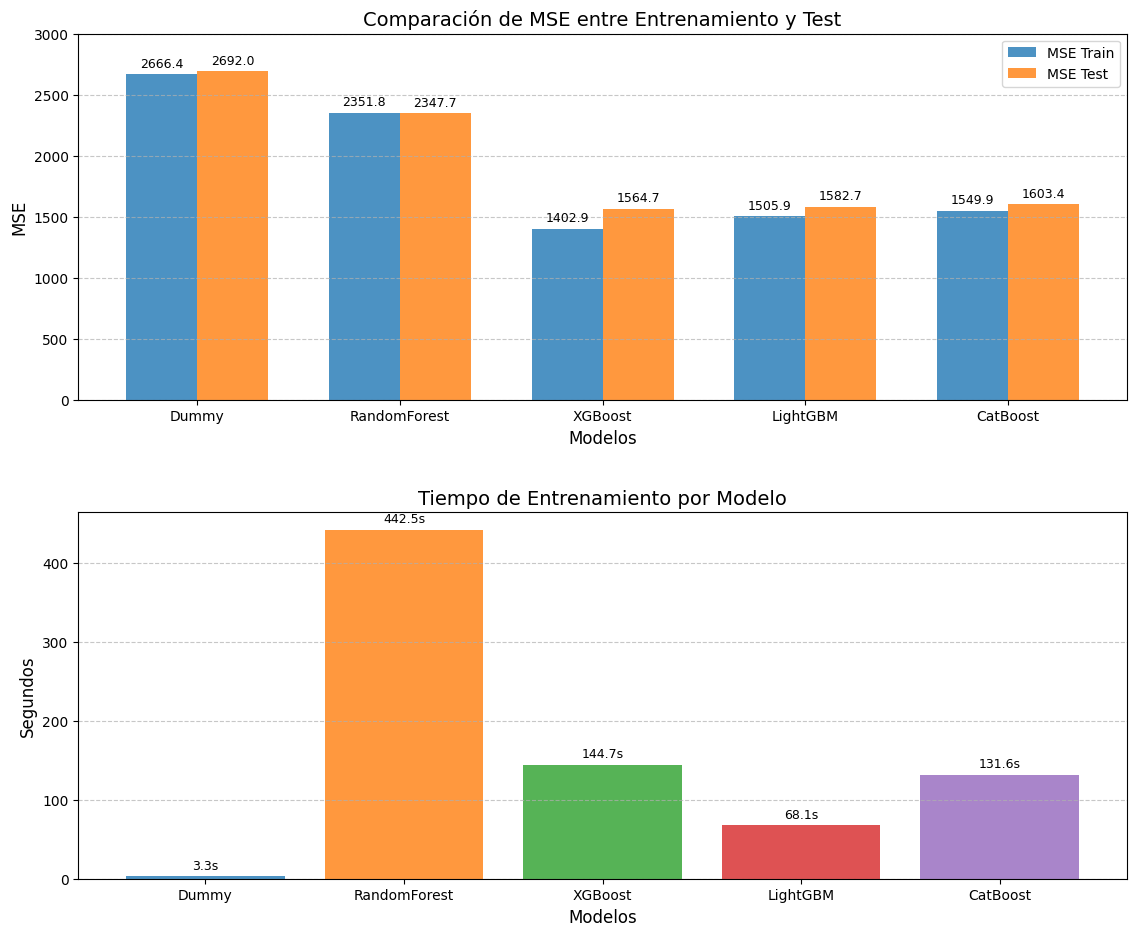

In [31]:
data = models_df.copy()

plt.figure(figsize=(12, 10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']


plt.subplot(2, 1, 1)
bar_width = 0.35
x = np.arange(len(data['modelo']))

train_bars = plt.bar(
    x - bar_width/2, 
    data['mse_train'], 
    width=bar_width,
    label='MSE Train',
    color='#1f77b4',
    alpha=0.8
)

test_bars = plt.bar(
    x + bar_width/2, 
    data['mse_test'], 
    width=bar_width,
    label='MSE Test',
    color='#ff7f0e',
    alpha=0.8
)

for bars in [train_bars, test_bars]:
    for bar in bars:
        height = bar.get_height()
        plt.annotate(
            f'{height:.1f}',
            xy=(bar.get_x() + bar.get_width()/2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center', 
            va='bottom',
            fontsize=9
        )

plt.title('Comparación de MSE entre Entrenamiento y Test', fontsize=14)
plt.xlabel('Modelos', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.xticks(x, data['modelo'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 3000)


plt.subplot(2, 1, 2)
time_bars = plt.bar(
    data['modelo'], 
    data['tiempo_entrenamiento'], 
    color=colors,
    alpha=0.8
)


for bar in time_bars:
    height = bar.get_height()
    plt.annotate(
        f'{height:.1f}s',
        xy=(bar.get_x() + bar.get_width()/2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center', 
        va='bottom',
        fontsize=9
    )

plt.title('Tiempo de Entrenamiento por Modelo', fontsize=14)
plt.xlabel('Modelos', fontsize=12)
plt.ylabel('Segundos', fontsize=12) 
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout(pad=3.0)
plt.show()

## Conclusiones
- El modelo dummy, sin hyperparametros, muy desprolijo pues tiene un desempeño acptable, aunque inferior (como se espera) a comparacion de los demas modelos
- Si bien el RandomForestRegressor no tiene el desempeño esperado, esto es probablemente debido a la cantidad de hiperparametros que tuve que quitar porque se iba haciendo eterno el entrenamiento.
- El mejor desempeño sin duda el GXboost, cosa acorde a la documentacion y experiencias de la gente que ocupa estos modelos.
- Un balance maravilloso se encuentra con el LightGBM

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter

- [x]  Jupyter Notebook está abierto
- [ ]  El código no tiene errores- [ ]  Las celdas con el código han sido colocadas en orden de ejecución- [ ]  Los datos han sido descargados y preparados- [ ]  Los modelos han sido entrenados
- [ ]  Se realizó el análisis de velocidad y calidad de los modelos